In [1]:
import warnings
warnings.filterwarnings('ignore')

#importing the libraries
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20.0, 10.0)
import seaborn as sns
import statsmodels.api as sm 
from sklearn.model_selection import train_test_split 
import scipy
from scipy.stats.stats import pearsonr
from sklearn.preprocessing import StandardScaler,scale
from scipy import stats

#pour afficher tous les colonnes d'un tableau
pd.set_option('display.max_columns', None)


In [2]:
data = pd.read_csv('/tmp/inputs/car_price_assignment.csv')
print("Dimension of our data set is: ")
print(data.shape)
print(data.head())

Dimension of our data set is: 
(205, 26)


,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [4]:
# 1. Separate the CarName variable to two columns: CompanyName and CarModel
#Chaque élément du colonne CarName sera diviser en deux String, et on va garder seulement le premier
CompanyName = data['CarName'].apply(lambda x : x.split(' ')[0])

#Insérer la nouvelle variable comme colonne dans notre dataset
data.insert(3,"CompanyName",CompanyName)

#Supprimer la colonne CarModel
data.drop(['CarName'],axis=1,inplace=True)

#Supprimer la colonne CarID, car elle n'a aucune effet sur notre dataset
data.drop(['car_ID'],axis=1,inplace=True)

print(data.head())

,symboling,CompanyName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,3,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,3,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,1,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,2,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,2,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [6]:
# Examine categorical variables and correct them if spelling errors are found

def get_variable_type(element):
    """
     Vérifier que les colonnes sont de variable continue ou catégorique.
     L'hypothèse est que si:
                  nombre unique <20 alors on suppose c'est catégorique
                  nombre unique> = 20 et dtype = [int64 ou float64] alors on suppose c'est continu
     """
    if element==0:
        return "Not Known"
    elif element < 20 and element!=0 :
        return "Categorical"
    elif element >= 20 and element!=0 :
        return "Contineous"
    
def predict_variable_type(metadata_matrix):
    metadata_matrix["Variable_Type"] = metadata_matrix["Valeurs_Uniques_Count"].apply(get_variable_type).astype(str)
    metadata_matrix["frequency"] = metadata_matrix["Null_Count"] - metadata_matrix["Null_Count"]
    metadata_matrix["frequency"].astype(int)
    return metadata_matrix 

def get_meta_data(dataframe) :
    """
     Méthode pour obtenir des métadonnées sur n'importe quel dataset transmis
    """
    metadata_matrix = pd.DataFrame({
                    'Datatype' : dataframe.dtypes.astype(str), # types de données de colonnes
                    'Non_Null_Count': dataframe.count(axis = 0).astype(int), # nombre total d'éléments dans les colonnes
                    'Null_Count': dataframe.isnull().sum().astype(int), # total des valeurs nulles dans les colonnes
                    'Null_Percentage': dataframe.isnull().sum()/len(dataframe) * 100, # pourcentage de valeurs nulles
                    'Valeurs_Uniques_Count': dataframe.nunique().astype(int) # nombre de valeurs uniques
                     })
    
    metadata_matrix = predict_variable_type(metadata_matrix)
    return metadata_matrix

def list_potential_categorical_type(dataframe,data) :
    print("*********colonnes de type de données catégoriques potentielles*********")
    metadata_matrix_categorical = dataframe[dataframe["Variable_Type"] == "Categorical"]
    
    length = len(metadata_matrix_categorical)
    if length == 0 :
        print("Aucune colonne catégorique dans un jeu de données donné.")  
    else :    
        metadata_matrix_categorical = metadata_matrix_categorical.filter(["Datatype","Valeurs_Uniques_Count"])
        metadata_matrix_categorical.sort_values(["Valeurs_Uniques_Count"], axis=0,ascending=False, inplace=True)
        col_to_check = metadata_matrix_categorical.index.tolist()
        name_list = []
        values_list = []
        
        for name in col_to_check :
            name_list.append(name)
            values_list.append(data[name].unique())
        
        temp = pd.DataFrame({"index":name_list,"Valeurs_Uniques":values_list})
        metadata_matrix_categorical = metadata_matrix_categorical.reset_index()
        metadata_matrix_categorical = pd.merge(metadata_matrix_categorical,temp,how='inner',on='index')
        display(metadata_matrix_categorical.set_index("index"))


metadata = get_meta_data(data)

#List potential columns of categorical variables
list_potential_categorical_type(metadata,data)

*********colonnes de type de données catégoriques potentielles*********


,Datatype,Valeurs_Uniques_Count,Valeurs_Uniques
index,,,
fuelsystem,object,8,"[mpfi, 2bbl, mfi, 1bbl, spfi, 4bbl, idi, spdi]"
enginetype,object,7,"[dohc, ohcv, ohc, l, rotor, ohcf, dohcv]"
cylindernumber,object,7,"[four, six, five, three, twelve, two, eight]"
symboling,int64,6,"[3, 1, 2, 0, -1, -2]"
carbody,object,5,"[convertible, hatchback, sedan, wagon, hardtop]"
drivewheel,object,3,"[rwd, fwd, 4wd]"
fueltype,object,2,"[gas, diesel]"
aspiration,object,2,"[std, turbo]"
doornumber,object,2,"[two, four]"


In [7]:
# In reviewing the above data, we found that few company names were identical but misspelled
# So we have to adjust things by replacing the values with one identical variable
data = data.replace(to_replace ="maxda", value ="mazda") 
data = data.replace(to_replace ="porcshce", value ="porsche") 
data = data.replace(to_replace ="toyouta", value ="toyota") 
data = data.replace(to_replace ="vokswagen", value ="volkswagen") 
data = data.replace(to_replace ="vw", value ="volkswagen")
data = data.replace(to_replace ="Nissan", value ="nissan")


# Visualization of independent variables
def pairplot(x_axis,y_axis) :
    sns.pairplot(data,x_vars=x_axis,y_vars=y_axis,height=4,aspect=1,kind="scatter")
    plt.show()


#Determiner la variable indépendante
y_vars=['price']

# Price VS Wheelbase - curbweight - boreratio
x_vars=['wheelbase','curbweight','boreratio']
pairplot(x_vars,y_vars)
print("At first glance, the 3 variables are positively correlated but spread at higher values.")

p1=data['wheelbase']
p2=data['curbweight']
p3=data['boreratio']

pearson_coeff, p_value = pearsonr(p1,data['price'])
print('\nWe can make sure of this by looking at the Coefficient of Correlation')
print('\nCoefficient of Correlation between Price and wheelbase:',pearson_coeff*100,'%')

pearson_coeff, p_value = pearsonr(p2,data['price'])
print('Correlation coefficient between Price and curbweight:',pearson_coeff*100,'%')

pearson_coeff, p_value = pearsonr(p3,data['price'])
print('Correlation coefficient between Price and boreratio: ',pearson_coeff*100,'%')

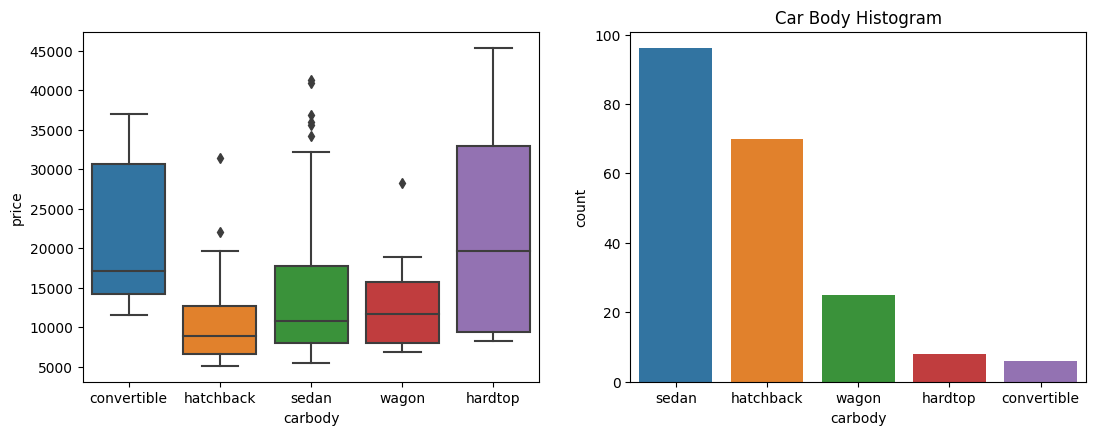

In [12]:
# Price VS carbody
plt.subplot(2,3,1)
sns.boxplot(x='carbody',y='price',data = data)

plt.subplot(2,3,2)
plt.title('Car Body Histogram')
order = data['carbody'].value_counts(ascending=False).index
sns.countplot(x='carbody', data=data, order=order)

plt.show()

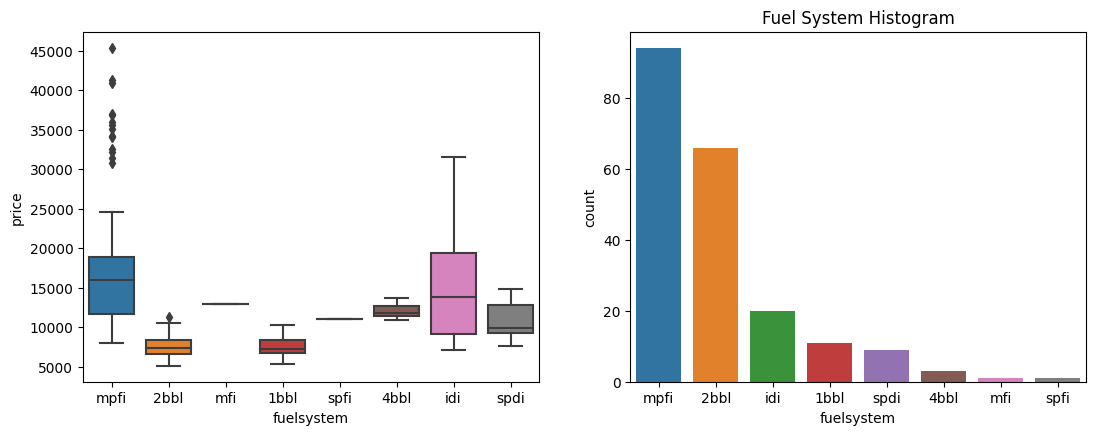

In [13]:
# Price VS fuelsystem
plt.subplot(2,3,1)
sns.boxplot(x='fuelsystem',y='price',data = data)

plt.subplot(2,3,2)
plt.title('Fuel System Histogram')
order = data['fuelsystem'].value_counts(ascending=False).index
sns.countplot(x='fuelsystem', data=data, order=order)

plt.show()

In [14]:
# Data preparation
metadata_matrix_dataframe = get_meta_data(data)
list_potential_categorical_type(metadata_matrix_dataframe,data)

*********colonnes de type de données catégoriques potentielles*********


,Datatype,Valeurs_Uniques_Count,Valeurs_Uniques
index,,,
fuelsystem,object,8,"[mpfi, 2bbl, mfi, 1bbl, spfi, 4bbl, idi, spdi]"
enginetype,object,7,"[dohc, ohcv, ohc, l, rotor, ohcf, dohcv]"
cylindernumber,object,7,"[four, six, five, three, twelve, two, eight]"
symboling,int64,6,"[3, 1, 2, 0, -1, -2]"
carbody,object,5,"[convertible, hatchback, sedan, wagon, hardtop]"
drivewheel,object,3,"[rwd, fwd, 4wd]"
fueltype,object,2,"[gas, diesel]"
aspiration,object,2,"[std, turbo]"
doornumber,object,2,"[two, four]"


In [15]:
data = data.drop(['carheight' ,'stroke' ,'compressionratio' ,'peakrpm' ,'carlength' ,'carwidth' ,'curbweight' ,'enginesize' ,'highwaympg'], axis=1)
print(data.head())

,symboling,CompanyName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,enginetype,cylindernumber,fuelsystem,boreratio,horsepower,citympg,price
0,3,alfa-romero,gas,std,two,convertible,rwd,front,88.6,dohc,four,mpfi,3.47,111,21,13495.0
1,3,alfa-romero,gas,std,two,convertible,rwd,front,88.6,dohc,four,mpfi,3.47,111,21,16500.0
2,1,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,ohcv,six,mpfi,2.68,154,19,16500.0
3,2,audi,gas,std,four,sedan,fwd,front,99.8,ohc,four,mpfi,3.19,102,24,13950.0
4,2,audi,gas,std,four,sedan,4wd,front,99.4,ohc,five,mpfi,3.19,115,18,17450.0


In [17]:
# Dummy Variables creation
def binary_dummy_replace(x) :
     return x.map({"gas":1,"diesel":0,
                   "std":1,"turbo":0,
                   "two":1, "four":0,
                   "front": 1, "rear": 0})
def dummies(x,df):  
    temp = pd.get_dummies(df[x], prefix=x, drop_first = True)
    
    #l = temp.columns.values
    #for nm in l:
        #newt=x+"_"+nm
        #temp.rename({nm: Replace_Name(x)+"_"+nm}, axis=1, inplace=True)
        
    #print(temp.columns.values)
        
    df = pd.concat([df, temp], axis = 1)
    df.drop([x], axis = 1, inplace = True)
    return df

data = dummies('symboling',data)
data = dummies('CompanyName',data)
data = dummies('fueltype',data)
data = dummies('aspiration',data)
data = dummies('doornumber',data)
data = dummies('carbody',data)
data = dummies('drivewheel',data)
data = dummies('enginelocation',data)
data = dummies('enginetype',data)
data = dummies('cylindernumber',data)
data = dummies('fuelsystem',data)

In [18]:
# Preparation of Train and Test data
# We specify this so that the train and test data set always have the same rows, respectively
cars_train, cars_test= train_test_split(data, train_size=0.67, test_size=0.33, random_state = 0)

# Feature Scaling: Train Set & Test Set
#we create an object of the class StandardScaler
sc = StandardScaler() 

col_to_scale = ['wheelbase','boreratio','horsepower','citympg','price',]

cars_train[col_to_scale] = sc.fit_transform(cars_train[col_to_scale])
cars_test[col_to_scale] = sc.fit_transform(cars_test[col_to_scale])


# Division into X_train and y_train sets for model construction

y_train = cars_train.loc[:,cars_train.columns == 'price']

X_train = cars_train.loc[:, cars_train.columns != 'price']

# Division into X_test and y_test sets

y_test = cars_test.loc[:,cars_test.columns == 'price']

X_test = cars_test.loc[:, cars_test.columns != 'price']

# 

In [21]:
# Training and Making predictions

lm = sm.OLS(y_train,X_train).fit()

y_pred=lm.predict(X_test)

# Anderson-Darling Test** and **Q-Q Plot of residuals
def normality_of_residuals_test(model):
    '''
    Function to establish the normal QQ graph of the residues and perform the Anderson-Darming statistical test to study the normality of the residuals.
    
    Arg:
    * model - OLS models adapted from statsmodels
    '''
    sm.ProbPlot(lm.resid).qqplot(line='s');
    plt.title('Q-Q plot');

    ad = stats.anderson(lm.resid, dist='norm')
    
    print(f'----Anderson-Darling test ---- \nstatistic: {ad.statistic:.4f}, critical value of 5%: {ad.critical_values[2]:.4f}')
    
normality_of_residuals_test(lm)

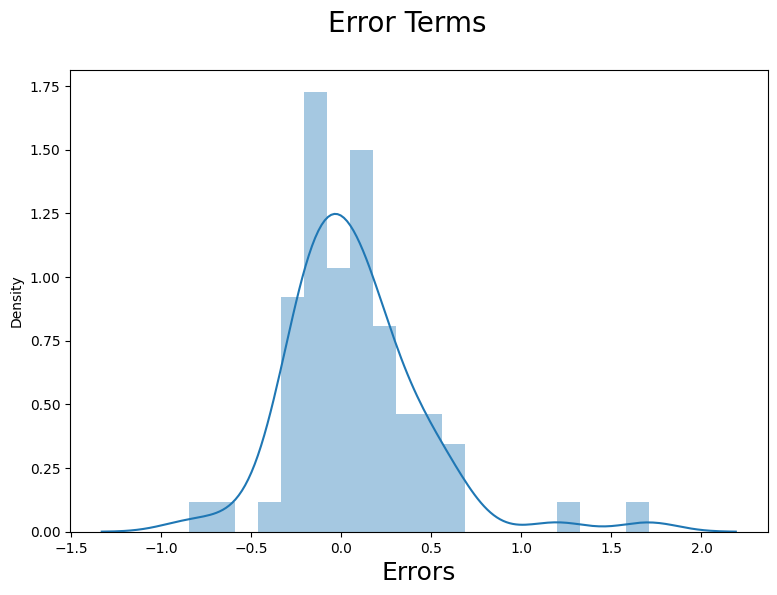

In [22]:
# Evaluation
# Residual analysis of the model

resid = y_test - y_pred

# A. Normality of the error distribution
fig = plt.figure(figsize=(9,6))
sns.distplot(resid, bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)
plt.show()

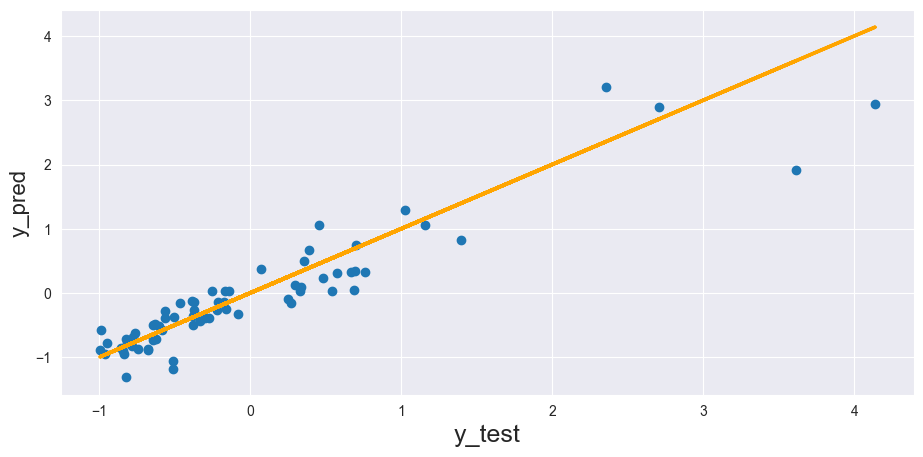

In [25]:
# Analysis:
# P-Value test **Goldfeld-Quandt** > 0.05, so we accept **H0** saying that the error terms are homoscedastic, which means that the residuals have a constant variance.
# Also, in the plot, the points are scattered randomly, no tendancy to be found, and the line doesn't have the form of an arch

fig = plt.figure(figsize=(11,5))
plt.scatter(y_test,y_pred)
plt.xlabel('y_test', fontsize=18)
plt.ylabel('y_pred', fontsize=16)

#Regression Line function
f = lambda x: x

# x values of line to plot
x = np.array(y_test)

# plot fit
plt.plot(x,f(x),lw=2.5, c="orange")
